# OpenStreetMap Project
## Seattle, WA USA

**Project Objective:**
This project utilizes an OpenStreetMap (OSM) of an area or city anywhere in the world and uses data munging techniques to assess the quality of the data for validity, accuracy, completeness, consistency and uniformity. Following this, the dataset is put into a SQLite database for analysis & querying. I choose the city of Seattle as it is my hometown.

**City Facts:** Seattle is a seaport city on the west coast of the United States and the seat of King County, Washington. With an estimated 704,352 residents as of 2016, Seattle is the largest city in both the state of Washington and the Pacific Northwest region of North America. In July 2016, Seattle was the fastest-growing major U.S. city, with a 3.1% annual growth rate. The city is situated on an isthmus between Puget Sound (an inlet of the Pacific Ocean) and Lake Washington, about 100 miles (160 km) south of the Canada–United States border. A major gateway for trade with Asia, Seattle is the fourth-largest port in North America in terms of container handling as of 2015 (From Wikipedia, the free encyclopedia).

In [1]:
from __future__ import division # Needed for Python 2.7
import xml.etree.cElementTree as ET
from collections import defaultdict
import pprint
import re
import codecs
import json
import csv
import cerberus
import schema
import sqlite3

OSM_FILE = "Seattle.osm"
SAMPLE_FILE = "sample.osm"

In [2]:
import platform # Tells version of Python

print(platform.python_version())

2.7.13


In [3]:
import os # Provides working path
os.getcwd()

'/home/kgarbutt/Desktop/Udacity/openstreetmap'

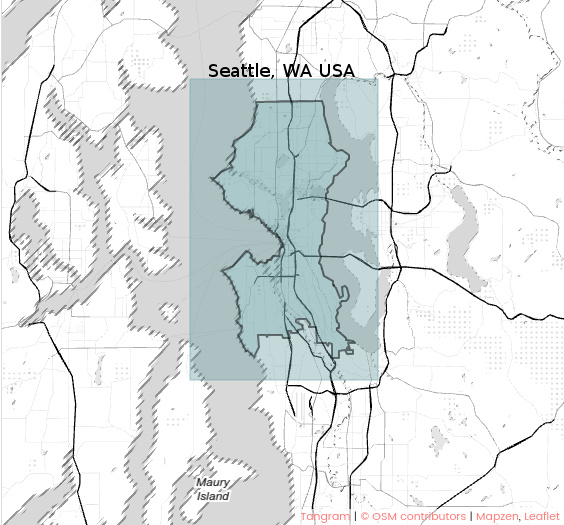

In [4]:
# Picture of the Mapzen Seattle Extract
# Used Gimp to add 'Seattle, WA USA' text to picture

from IPython.display import Image
Image(filename= 'Mapzen Seattle Extract.jpg')

In [5]:
# Get the size Seattle OSM Extract in MB

print ('The Seattle.osm file is {} MB'.format(os.path.getsize('Seattle.osm')/1.0e6))

The Seattle.osm file is 564.854939 MB


### Problems Encountered in the Map

After downloading the the OpenStreetMap as an xml dataset, and running it though this python code, I noticed the following problems. The street names were not consistent, and the zip codes (while appearing clean) needed to by audited for uniformity.

Additionally, the dataset was very large. This made it very difficult to 'simply' open it for viewing. I had to rely on the code & the output files to understand the problems. And finally, I had to be careful of my output in Jupyter as I crashed my Jupyter file once.

In [6]:
# This code will step through the very large osm file in increments based on the value of k.
# Write to a SAMPLE_FILE
# Without this code, my computer killed the python process as my 16G memory was exceeded.

k = 10 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')

In [7]:
# Count the top level elements in our osm file
# Inter-parse one element at a time and add them to a dictionary if not already present

def count_tags(filename):
    # YOUR CODE HERE
    tags = {}
    for event, element in ET.iterparse(filename):
        if element.tag in tags.keys():
            tags[element.tag] += 1
        else:
            tags[element.tag] = 1
    return tags

count_tags(OSM_FILE)

{'bounds': 1,
 'member': 31043,
 'nd': 2700882,
 'node': 2440536,
 'osm': 1,
 'relation': 2466,
 'tag': 1800754,
 'way': 284928}

As we can see from counting the tags, the major elements are member, nd, node, tag, way.

Using regular expression, we will check our osm file for certain patterns in the tags. This will help us identify potential data problems. We will define our tag categories in a Python set as such:

**lowr** = <span style="color:blue"> "lower"</span>, for tags that contain only lowercase letters and are valid,  
**lo_co** = <span style="color:blue"> "lower_colon"</span>, for otherwise valid tags with a colon in their names,  
**probchar** = <span style="color:blue"> "problemchars"</span>, for tags with problematic characters, and  
**other** = <span style="color:blue"> "other"</span>, for other tags that do not fall into the other three categories.

In [8]:
# Regular expression for each category
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

lowr = set()
lo_co = set()
probchar = set()
other = set()

def key_type(element, keys):
    # YOUR CODE HERE
    if element.tag == "tag":
        low = lower.search(element.attrib['k'])
        low_col = lower_colon.search(element.attrib['k'])
        prob = problemchars.search(element.attrib['k'])
        if low:
            keys["lower"] += 1
            lowr.add(element.attrib['k']) 
        elif low_col:
            keys["lower_colon"] +=1
            lo_co.add(element.attrib['k']) 
        elif probchar:
            keys["problemchars"] +=1
            probchar.add(element.attrib['k']) 
        else:
            keys["other"] +=1
            other.add(element.attrib['k'])
    return keys

def write_data(data, filename):
    with open(filename, 'wb') as f:
        for x in data:
            f.write(x + "\n")

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}

    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    
    write_data(lowr, 'lower.txt')
    write_data(lo_co, 'lower_colon.txt')
    write_data(probchar, 'problem_chars.txt')
    write_data(other, 'other.txt')
    return keys

keys = process_map(OSM_FILE)
pprint.pprint(keys)

{'lower': 798939, 'lower_colon': 982634, 'other': 19181, 'problemchars': 0}


In [9]:
# This code identifies problem street name mappings, and is used as a tool to find, 
# correct & validate their names

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

# UPDATE THIS VARIABLE
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane",
            "Road", "Trail", "Parkway", "Commons", "North", "South", "East", "West",
            "Northwest", "Southwest", "Northeast", "Way", "Terrace"]

# UPDATE THIS VARIABLE
mapping = { "St": "Street",
            "St.": "Street",
           "Rd.": "Road",
            "Ln": "Lane",
            "raod": "Road",
            "Ave": "Avenue",
            "Blvd": "Boulevard",
            "N.E.": "Northeast",
            "15TH": "15th",
            "NE": "Northeast",
            "NW": "Northwest",
            "S": "South"
           }
# find street name using regex & add if not in street name list
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

# returns true if key tag is a street name
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

# writes the file
def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

name_list = []

# audits the street name
def audit_street(osmfile):
    osm_file = open(osmfile, "r")
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag in["node", "way", "relation"] :
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    better_name = update_name(tag.attrib['v'])
                    name_list.append(better_name)
    osm_file.close()
    return name_list

def update_name(name):
    # YOUR CODE HERE
    for n in name.split():
        if n in mapping:
            name = name.replace(n, mapping[n])
    return name

# Prints out uncorrected OSM street names
#st_types = audit(OSM_FILE)
#pprint.pprint(dict(st_types))

# Prints corrected OSM street names
#st_name = audit_street(SAMPLE_FILE)
#pprint.pprint(st_name)


### Auditing the postal codes

While the postal codes looked clean, I wanted to audit them to ensure that they were all 5-number zip-codes such as 98133. Importantly, it was here that I began to realize that this dataset had been highly edited.

In [10]:
# Audits the postal codes

POSTCODE = re.compile(r'[A-z]\d[A-z]\s?\d[A-z]\d')

def audit_postcode(filename):
    post_file = open(OSM_FILE, "r")
    for event, elem in ET.iterparse(post_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if tag.attrib['k'] == 'addr:postcode':
                    post_code = re.sub(" ", "", tag.attrib['v'].strip())
                    m = POSTCODE.match(post_code)
                    if m is None:
                        print post_code      
    post_file.close()

#audit_postcode(OSM_FILE)


In [ ]:
#OSM_PATH = "example.osm"
OSM_PATH = OSM_FILE

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema.schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

# Shape the entries in the dictionary for importing into sqlite
def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    # YOUR CODE HERE
    
    if element.tag == 'node':
        node_attribs["id"]=element.get("id")
        node_attribs["user"]=element.get("user")
        node_attribs["uid"]=element.get("uid")
        node_attribs["version"]=element.get("version")
        node_attribs["lat"]=element.get("lat")
        node_attribs["lon"]=element.get("lon")
        node_attribs["timestamp"]=element.get("timestamp")
        node_attribs["changeset"]=element.get("changeset")
        
        for child in element:
            if child.tag=="nd":
                d={}
                d["id"]=element.attrib["id"]
                d["node_id"]=child.attrib["ref"]
                d["position"]=count
                way_nodes.append(d)
                count += 1
            if child.tag=="tag":
                d={}
                d["id"]=element.attrib["id"]
                d["value"]=child.attrib["v"]
                if PROBLEMCHARS.match(child.attrib["k"]):
                    continue
                elif ":" in child.attrib["k"]:
                    d["type"]=child.attrib["k"].split(":")[0]
                    d["key"]=child.attrib["k"].split(":", 1)[1]
                else:
                    d["key"]=child.attrib["k"]
                    d["type"]="regular"
                tags.append(d)   
        
        return {'node': node_attribs, 'node_tags': tags}
        #print {'node': node_attribs, 'node_tags': tags}
        
    elif element.tag == 'way':
        count = 0
        for field in way_attr_fields:
            way_attribs[field]=element.attrib[field]
        for child in element:
            if child.tag=="nd":
                d={}
                d["id"]=element.attrib["id"]
                d["node_id"]=child.attrib["ref"]
                d["position"]=count
                way_nodes.append(d)
                count += 1
            if child.tag=="tag":
                d={}
                d["id"]=element.attrib["id"]
                d["value"]=child.attrib["v"]
                if PROBLEMCHARS.match(child.attrib["k"]):
                    continue
                elif ":" in child.attrib["k"]:
                    d["type"]=child.attrib["k"].split(":")[0]
                    d["key"]=child.attrib["k"].split(":", 1)[1]
                else:
                    d["key"]=child.attrib["k"]
                    d["type"]="regular"
                tags.append(d)

        #return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}
        print {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])

if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(OSM_PATH, validate=True)

## Prepare for SQL Database

This step is very important. By using a SQL database, it will make querying a very large dataset much more efficient. 

To prepare the data for importing into the SQL database, we first parse the elements in the OSM XML file line by line transforming them to a tabular format which allows for writing to the csv files. The csv files can then be imported into the SQL database as tables. To help with the formating, we used a 'shape_element' function to transform each element into the correct format, then iteratively processes each XML element while writing to the csv file with the help of the process_map function.

In [11]:
sqlite_file = "seattle.db" # Name of sqlite3 db file
conn = sqlite3.connect(sqlite_file) # Connect to db
cur = conn.cursor() # Get curser object


cur.execute('DROP TABLE IF EXISTS way_tags') # Drop table if already present
conn.commit() # commit changes

# All tables for db were created like this (Only way_tags table is shown):

# Create the way_tags table, specifying the column names and data types:
cur.execute('''
    CREATE TABLE way_tags(id INTEGER, key TEXT, value TEXT,type TEXT)
''')

# Commit the changes
conn.commit()


In [ ]:
# WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']

with open('ways_tags.csv','rb') as fin:
    dr = csv.DictReader(fin) # Comma is default delimiter
    to_db = [(i['id'], i['key'], i['value'], i['type']) for i in dr]
    cur.executemany("INSERT INTO way_tags(id, key, value, type) VALUES (?,?,?,?);", to_db)
    
conn.commit()

# Check that the data imported correctly
cur.execute('SELECT * FROM way_tags')
all_rows = cur.fetchall()
print('1):')

# Close the connection:
conn.close()

## Data Overview and Additional Ideas
This section contains basic statistics about the dataset, the SQL queries used to gather them, and some concluding thoughts about the dataset.

### File sizes

In [12]:
# File sized are converted from bytes to MB
import os
print('The Seattle.osm file is {} MB'.format(os.path.getsize('Seattle.osm')/1.0e6))
print('The project.db file is {} MB'.format(os.path.getsize('seattle.db')/1.0e6))
print('The nodes.csv file is {} MB'.format(os.path.getsize('nodes.csv')/1.0e6))
print('The nodes_tags.csv file is {} MB'.format(os.path.getsize('nodes.csv')/1.0e6))
print('The ways.csv file is {} MB'.format(os.path.getsize('ways.csv')/1.0e6))
print('The ways_tags.csv is {} MB'.format(os.path.getsize('ways_tags.csv')/1.0e6))
print('The ways_nodes.csv is {} MB'.format(os.path.getsize('ways_nodes.csv')/1.0e6)) 


The Seattle.osm file is 564.854939 MB
The project.db file is 207.54432 MB
The nodes.csv file is 210.601201 MB
The nodes_tags.csv file is 210.601201 MB
The ways.csv file is 4.1e-05 MB
The ways_tags.csv is 1.9e-05 MB
The ways_nodes.csv is 2.1e-05 MB


### Number of nodes

In [13]:
cur.execute("SELECT COUNT(*) FROM node;")
print(cur.fetchall())

[(2470494,)]


In [14]:
cur.execute("SELECT COUNT(*) FROM way;")
print(cur.fetchall())

[(0,)]


### Top 10 contributing users

In [15]:
cur.execute("SELECT user, COUNT(*) as num FROM \
(SELECT user FROM node UNION ALL SELECT user FROM way) \
GROUP BY user ORDER BY num DESC LIMIT 10;")
pprint.pprint(cur.fetchall())

[(u'Glassman', 835914),
 (u'SeattleImport', 665157),
 (u'seattlefyi', 90402),
 (u'sctrojan79', 85824),
 (u'Glassman_Import', 55643),
 (u'Foundatron', 55374),
 (u'zephyr', 52267),
 (u'jeffmeyer', 48932),
 (u'lukobe', 42110),
 (u'Omnific', 41622)]


### Number of unique users

In [16]:
cur.execute("SELECT COUNT(DISTINCT(uid)) FROM (SELECT uid FROM node UNION ALL \
SELECT uid FROM way);")
print(cur.fetchall())

[(1045,)]


### Top 10 Postal Codes

In [17]:
cur.execute("SELECT value, COUNT(value) FROM node_tags \
GROUP BY value HAVING key = 'postcode' ORDER BY COUNT(value) DESC LIMIT 10;")
pprint.pprint(cur.fetchall())

[(u'98103', 6843),
 (u'98107', 4532),
 (u'98034', 3867),
 (u'98122', 3686),
 (u'98115', 3473),
 (u'98108', 3237),
 (u'98144', 3227),
 (u'98118', 3115),
 (u'98105', 3053),
 (u'98125', 2834)]


### Top 10 Tourism Groups

In [18]:
import pprint
cur.execute ("SELECT tags.value, COUNT(*) as COUNT FROM (SELECT * FROM node_tags UNION ALL \
             SELECT * FROM way_tags) tags WHERE tags.key LIKE 'tourism' \
             GROUP BY tags.value ORDER BY count DESC;")
pprint.pprint(cur.fetchall())

[(u'artwork', 486),
 (u'information', 131),
 (u'viewpoint', 59),
 (u'picnic_site', 45),
 (u'attraction', 19),
 (u'hotel', 17),
 (u'museum', 13),
 (u'motel', 4),
 (u'guest_house', 3),
 (u'hostel', 3),
 (u'apartment', 2),
 (u'camp_site', 1),
 (u'chalet', 1),
 (u'gallery', 1),
 (u'point of interest', 1)]


### Number of Artwork Sculptures

In [19]:
cur.execute("SELECT node_tags.value, COUNT(*) as num FROM node_tags JOIN (SELECT id \
            FROM node_tags WHERE value = 'sculpture') i ON node_tags.id = i.id \
            WHERE node_tags.key = 'artwork_type' GROUP BY node_tags.value;")

pprint.pprint(cur.fetchall())

[(u'sculpture', 290)]


### Schools

In [20]:
cur.execute("SELECT node_tags.value, COUNT(*) as num FROM node_tags JOIN (SELECT id \
            FROM node_tags WHERE value = 'school') i ON node_tags.id = i.id \
            WHERE node_tags.key = 'name' GROUP BY node_tags.value \
            ORDER BY num DESC LIMIT 10;")

pprint.pprint(cur.fetchall())

[(u'Interagency Ryther Center', 2),
 (u'4/4 School of Music', 1),
 (u'ALPS Language School', 1),
 (u'APP at Lincoln', 1),
 (u'Al Studio Fine Art Classes', 1),
 (u'Alpha Montessori School', 1),
 (u'American Indian Heritage Middle College', 1),
 (u'Antioch University', 1),
 (u'Assumption Saint Bridget School', 1),
 (u'Bai He Chinese School', 1)]


### Top Restaurants Counts for in each city

In [21]:
cur.execute("SELECT node_tags.value, COUNT(*) as num FROM node_tags \
JOIN (SELECT DISTINCT(id) FROM node_tags WHERE value = 'restaurant') \
i ON node_tags.id = i.id WHERE node_tags.key = 'city'\
GROUP BY node_tags.value ORDER BY num DESC;")

pprint.pprint(cur.fetchall())

[(u'Seattle', 775), (u'Kirkland', 9), (u'Renton', 2), (u'Shoreline', 1)]


# Additional Ideas

The real benefit to a project like this is that once the map is parsed and the SQLite database is populated -- it allows for a very efficient way to query the database. This would have been virtually impossible from the original file.

## Problems encountered in the map:

There were certainly problems with this project, and with the dataset. As for the project, the map file was very large. Because of this, I had to rely on the coding & the output files to understand the problems in the dataset. For example, while the zip codes appeared to be correct, the code to audit them provided a very convenient way to validate them.

As for the dataset, there were some major problems too, and they weren't obvious until I started processing the XML map. The first clue was that the zip codes appeared correct or already edited. This was my first clue that the dataset (as I believed) had already been highly edited despite the map file being rather large in size. The second problem was an even bigger clue that there were problems with the dataset, and that my suspicions about it were becoming true. All of the way elements in the file were empty. There were no way elements to scrape. The three way csv files I created were empty. They only contained a header. Taken all together, I didn't let this deter me. I continued to process the file, and I when I built the database, I included the empty way csv files into the database. And when I queried the database, I queried it as if the way files had been populated. After finishing it, I was happy that I continued with this line of thought as I learned so much more about querying the database.

Also, the data in the dataset isn’t complete. For example, I queried for top restaurants and the output included a few restaurants in Kirkland, Renton, and Shoreline. These are cities surrounding Seattle so they should never have been in the output in the first place. And when I examined the Seattle restaurants alone, the returning output of restaurants was 775. This couldn’t possible be correct for a city the size of Seattle. To investigate this, I did a query on yelp.com (a website that lists restaurant reviews), and sure enough, there are 7301 restaurants in Seattle. Even if yelp isn’t correct, it does illustrate that the dataset isn’t complete.

## Additional suggestions for improving the data or its analysis:

There are a few ways which the data in OpenStreetMap dataset could be improved. One of these ways is to create an on-line editor where the average person could contribute to the functionality of the data by adding information about their own home towns. For example, they could add new restaurants, museums, parks, etc. This on-line editor wouldn’t have to be limited to just physical places like restaurants, it could include streets, and addresses. It could be broken up into sections so the contributions could be limited to, for example, just parks or whatever the person felt comfortable contributing to. But for this to be successful, the editor would have to appeal to the average person, and not just to programmers or developers. Additionally, there could be incentives to contributing to the maps like posting the best contributors on the main OpenStreetMap website. This simple incentive could create a competition to be recognized as a top contributor. Interestingly, I queried OpenStreetMap for an editor, and I found that they have an editor. However, it isn’t user-friendly, and it certainly isn’t for the average person. All of this only reinforces what I said about the way the editor should operate.

Another way to improve the dataset would be to cross reference the data between the node elements and that way elements. Missing data could be corrected or validated. This could include missing company names, addresses, incorrect zip codes, etc. This could be an important component of the data validity as it would correct missing information, and would go a long way towards making the dataset more accurate.

And finally, taken these ideas together – cross referencing between the node and way elements, using a user-friendly editor, and adding an incentive – it may be the beginning to improving the quality of the datasets.

## Benefits and anticipated problems in implementing the improvements:

The benefits to introducing a more user friendly on-line editor where the average person could edit the maps would be more access to the maps, and better quality datasets. This would make the maps more accurate if more people were editing them. One of the ways to achieve this would be to provide a mobile app for the editor. An app would allow for more individuals to edit the map, and might even be used by businesses to update their own information. With the use of the mobile app, there would be greater access to the maps, and this would generate more interest in the project as a whole. Even if the mobile app isn’t attainable at the moment, a more user-friendly on-line editor would be beneficial. While it won’t have the same impact as an app might have, it will contribute to wider usage. And with more interest in the project this would propel the whole entire project forward with better datasets, more uses for the maps, more access to the maps, and a much larger community to keep moving the project forward.

The benefits to providing an incentive to contributing to the maps would be more accurate maps, and more contributors who would want to be recognized as a top contributor. Since the OpenStreetMap project is completely open-source, it would be difficult to have an incentive that would be a paid prize incentive. If, however, companies contributed to these incentives in return for more access to their businesses then this would certainly lead to the possibility of more people editing the map to win the prize.  And even if the incentive is only a friendly acknowledgment on the main website this might be enough to improving the maps.  In any case, an incentive would only help with the items we discussed.

The benefits to cross referencing the node and way elements would be more accurate maps, and more widespread usage. By cross referencing between the node and way elements, we could ensure that missing data between them was corrected. This would lead to more accurate maps, and with more accurate maps it would lead to more widespread usage. The key here is more accurate maps. Imagine if the maps were accurate enough that they could replace Google Maps or were accurate enough to be on other mapping devices. While just cross referencing between them alone isn’t enough, it would be the beginning to having accurate maps which would lead to more widespread usage.

One of the anticipated issues to the on-line editor would be that there would be a greater need for documentation on how to use the editor. With more people using it, there would be a greater demand for better documentation. It is also possible, that such a demand would drive the development of the documentation. Additionally, with more people using it and in keeping with technology, a user forum would be needed to discuss the latest issues with using the map editor, to highlight specific time lines for the map editor, and just to handle the need to share the learning of the editor. Interestingly, I queried the documentation for OpenStreetMap, and while there is some documentation – it does need improvement. This only reinforces our argument for better documentation.

Some of the anticipated issues related to an incentive program would be the need to update the website to reflect the top contributors. More web developers would be needed to keep the updates current, and to not over burden the already present web developers working on the website. Additionally, someone would have to be in charge of soliciting contributions from businesses to help fund a paid prize incentive. This by itself would be no easy task as the OpenStreetMap is completely open source, but it would certainly contribute to the promoting of the project as a whole.   

And finally, some of the anticipated issues related to cross referencing between the node and ways elements. For this to be successful software would have to be written which could facilitate the cross referencing.  To do this programmers would have to be hired to begin this development. Additionally, it would have to be decided on what to do with data that still isn’t complete even after cross referencing it. As for the cross referencing, it would certainly lead to more complete map datasets.

In conclusion, even though OpenStreetMap is open source, and while they have done a great job with it as such – imagine what it would be like if they could implement the ideas we have put forth here. They would certainly have better maps that were more complete, and with richer information that would allow someone to ask specific questions about mapping content like, “where is the closest hospital”, etc. And this would then allow OpenStreetMap to have more usage on many more devices and more worldwide usage as a mapping application. Then it would truly be ready to compete with the likes of Google Maps.

## References

Preparing for database - SQL:
https://discussions.udacity.com/t/creating-db-file-from-csv-files-with-non-ascii-unicode-characters/174958/5

Class lecture notes, homework assignments, quizes, Udacity forum, and OSM casestudy


Ken Garbutt, August, 2017